##Model2_FT - FineTuning using Densenet201

by Kaushik Srivatsan - CDS - kaushik.s-25@scds.saiuniversity.edu.in



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
print(tf.__version__)

from tensorflow import keras
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline

import glob
import PIL
from PIL import Image

2.15.0


## Loading the preprocessed dataset

In [3]:
# load numpy array from npy file
from numpy import load

X_train_std = load('/content/drive/MyDrive/Models/X_train_std_model1.npy')
X_test_std = load('/content/drive/MyDrive/Models/X_test_std_model1.npy')

y_train = load('/content/drive/MyDrive/Models/y_train_model1.npy')
y_test = load('/content/drive/MyDrive/Models/y_test_model1.npy')

In [4]:
print("X_train_std_shape: {}".format(X_train_std.shape))
print("X_test_std_shape: {}".format(X_test_std.shape))

X_train_std_shape: (373, 299, 299, 3)
X_test_std_shape: (125, 299, 299, 3)


##Loading the Transfer-learning Model

In [5]:
model2_FT = keras.models.load_model('/content/drive/MyDrive/Models/model2_TL.h5')
model2_FT.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 305, 305, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 150, 150, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 150, 150, 64)         256       ['conv1/conv[0][0]']      

## Modifyng and Fine tuning the layers to be trained

In [6]:

total_layers = len(model2_FT.layers)
split_index = int(0.35 * total_layers)

for layer in model2_FT.layers[:split_index]:
    layer.trainable = False

for layer in model2_FT.layers[split_index:]:
    layer.trainable = True

## Compiling and Training the Model

In [7]:
model2_FT.compile(loss='sparse_categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

callbacks_FineTune = [
             keras.callbacks.ModelCheckpoint("bestFT2.h5",
                                             monitor='val_accuracy',
                                             save_weights_only=True,
                                             save_best_only=True)
]

history_FineTune = model2_FT.fit(x = X_train_std, y = y_train, epochs=10,
                                      validation_split=0.1, batch_size=16, callbacks=callbacks_FineTune)

Epoch 1/10
21/21 [==============================] - 124s 1s/step - loss: 1.1181 - accuracy: 0.6806 - val_loss: 33.8642 - val_accuracy: 0.1842
Epoch 2/10
21/21 [==============================] - 7s 352ms/step - loss: 0.6563 - accuracy: 0.7701 - val_loss: 18.8863 - val_accuracy: 0.5526
Epoch 3/10
21/21 [==============================] - 6s 304ms/step - loss: 0.7855 - accuracy: 0.8119 - val_loss: 42.8772 - val_accuracy: 0.3684
Epoch 4/10
21/21 [==============================] - 6s 308ms/step - loss: 0.3230 - accuracy: 0.8896 - val_loss: 6.5055 - val_accuracy: 0.4474
Epoch 5/10
21/21 [==============================] - 6s 304ms/step - loss: 0.2884 - accuracy: 0.8955 - val_loss: 9.6068 - val_accuracy: 0.5526
Epoch 6/10
21/21 [==============================] - 8s 375ms/step - loss: 0.2293 - accuracy: 0.9194 - val_loss: 1.2646 - val_accuracy: 0.7632
Epoch 7/10
21/21 [==============================] - 7s 323ms/step - loss: 0.1288 - accuracy: 0.9552 - val_loss: 2.0049 - val_accuracy: 0.6842
Epoc

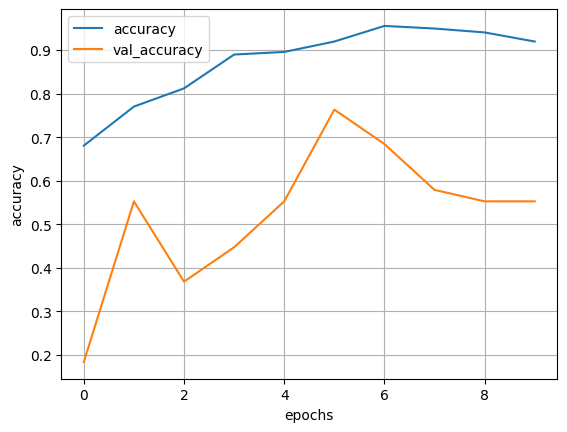

In [8]:
keys = ['accuracy', 'val_accuracy']
progress = {k:v for k,v in history_FineTune.history.items() if k in keys}

import pandas as pd
pd.DataFrame(progress).plot()

plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.grid(True)
plt.show()

## Evaluating the Model with Best weights

In [9]:
model2_FT.load_weights("bestFT2.h5")

testLoss_FineTune, testAccuracy_FineTune = model2_FT.evaluate(x = X_test_std, y = y_test)

print("Test-loss: %f, Test-accuracy: %f" % (testLoss_FineTune, testAccuracy_FineTune))

4/4 [==============================] - 24s 4s/step - loss: 1.2774 - accuracy: 0.7600
Test-loss: 1.277431, Test-accuracy: 0.760000


## Checking its  Performance

In [10]:
y_proba = model2_FT.predict(X_test_std)
y_predict = np.argmax(y_proba, axis=-1)
print(y_predict)

4/4 [==============================] - 5s 289ms/step
[1 2 1 1 0 3 3 1 1 0 3 2 3 1 1 3 1 3 1 1 1 1 3 2 1 3 3 2 3 3 3 3 1 0 1 0 2
 3 2 2 3 3 2 0 1 2 1 3 2 3 1 1 3 3 0 0 2 1 2 2 0 3 1 3 3 3 2 1 1 1 2 3 2 3
 3 1 3 1 0 3 1 1 3 2 2 0 3 3 1 0 0 1 2 3 3 2 2 0 1 1 1 1 3 1 0 1 3 1 3 3 3
 1 3 2 3 3 0 3 1 1 3 1 3 3 0]


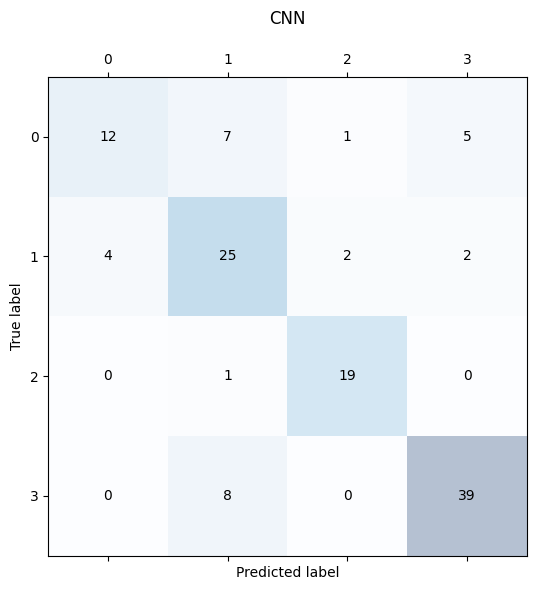

In [11]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true = y_test, y_pred = y_predict)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

ax.title.set_text('CNN\n')
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig("ConfusionMatrix.png", dpi=300, format='png', pad_inches=0.3)
plt.show()

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

pScore = precision_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("Precision: ", pScore)

pScore = precision_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("Precision: ", pScore)

rScore = recall_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("Recall: ", rScore)

fScore = f1_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("F1-score: ", fScore)

print("\n\n\n")

rScore = recall_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("Recall: ", rScore)

fScore = f1_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("F1-score: ", fScore)

print("\n\n\n")

Precision:  0.7679400366335679
Precision:  0.7679400366335679
Recall:  0.76
F1-score:  0.7555682925816679




Recall:  0.76
F1-score:  0.7555682925816679






## Saving the Fine-Tuned Model

In [13]:
model2_FT.save('/content/drive/MyDrive/Models/model2_FT.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
